# Assessment 1 - PySpark Dataframe

In [157]:
"""
Dataset Description:
1. age	numeric
2. job	type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
4. education	(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no', 'yes', 'unknown')
6. balance
7. housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
8. loan has a personal loan? (categorical: 'no', 'yes', 'unknown')

# related to the last contact of the current campaign:
9. contact communication type (categorical: 'cellular', 'telephone')
10. month Month of last contact (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11. day_of_the_month last contact day of the week (integer)
12. duration last contact duration, in seconds (numeric).

#Important note: this attribute highly affects the output target (example, if duration=0 then y='no').
#Yet, the duration is not known before a call is performed. Also, after the end of the call “y” is obviously known.
#Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
13.	campaign: number of times a customer was contacted during the campaign (numeric, includes last contact)
14.	pdays: number of days passed after the customer was last contacted from a previous campaign (numeric; -1 means customer was not previously contacted)
15.	previous: number of times the customer was contacted prior to (or before) this campaign (numeric)
16.	poutcome: outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success')
17. deposit: has the customer subscribed a term deposit? (binary: 'yes', 'no')

Analysis tasks that the marketing team has asked you to perform:
1.[ok]	Load data and create a Spark data frame 
2.[ok]	Give marketing success rate (No. of people subscribed / total no. of entries)   
3.[ok]	Give marketing failure rate
4.[ok]	Give the maximum, mean, and minimum age of the targeted customer
5.[ok]	Check the quality of customers by checking average balance, median balance of customers
6.[ok]	Check if age matters in marketing subscription for deposit
7.[ok]	Check if marital status mattered for a subscription to deposit
8.[ok]	Check if age and marital status together mattered for a subscription to deposit scheme
9.[ok]	Do feature engineering for the bank and find the right age effect on the campaign

"""


"\nDataset Description:\n1. age\tnumeric\n2. job\ttype of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')\n3. marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)\n4. education\t(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')\n5. default: has credit in default? (categorical: 'no', 'yes', 'unknown')\n6. balance\n7. housing: has housing loan? (categorical: 'no', 'yes', 'unknown')\n8. loan has a personal loan? (categorical: 'no', 'yes', 'unknown')\n\n# related to the last contact of the current campaign:\n9. contact communication type (categorical: 'cellular', 'telephone')\n10. month Month of last contact (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')\n11. day_of_the_month last contact day of the week (integer)\n12. duration l

# Installing PySpark

In [158]:
pip install pyspark

# Importing libraries

In [159]:
import pandas as pd
import numpy as np
import pyspark
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col,array_contains, count, isnan, when
from pyspark.mllib.feature import StandardScaler,PCA
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import VectorAssembler


# Pandas Data Frame

In [160]:
data = pd.read_csv('Project 1_dataset.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,95,retired,married,secondary,0,0,0,0,telephone,1,oct,215,1,-1,0,success,1
1,93,retired,married,unknown,0,775,0,0,cellular,4,aug,476,2,13,9,success,1
2,93,retired,married,unknown,0,775,0,0,cellular,22,jul,860,2,177,7,failure,0
3,92,retired,married,unknown,0,775,0,0,cellular,22,oct,313,3,-1,0,failure,0
4,92,retired,married,unknown,0,775,0,0,telephone,26,jan,164,4,96,3,nonexistent,0


In [161]:
data.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.336666
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.472575
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,1.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


# Initializing SparkSession

In [162]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


# Reading CSV file and formating spark schema

In [163]:
#df = spark.read.csv('Project 1_dataset.csv')

In [164]:
rdd_dataset = spark.read.csv("Project 1_dataset.csv").rdd

In [165]:
schema = StructType() \
      .add("age",IntegerType(),True) \
      .add("job",StringType(),True) \
      .add("marital",StringType(),True) \
      .add("education",StringType(),True) \
      .add("default",IntegerType(),True) \
      .add("balance",IntegerType(),True) \
      .add("housing",IntegerType(),True) \
      .add("loan",IntegerType(),True) \
      .add("contact",StringType(),True) \
      .add("day",IntegerType(),True) \
      .add("month",StringType(),True) \
      .add("duration",IntegerType(),True) \
      .add("campaign",IntegerType(),True) \
      .add("pdays",IntegerType(),True) \
      .add("previous",IntegerType(),True) \
      .add("poutcome",StringType(),True) \
      .add("deposit",IntegerType(),True,)
      
spark_df = spark.read.format("csv") \
      .option("header", True) \
      .schema(schema) \
      .load("Project 1_dataset.csv")
spark_df.printSchema()
spark_df.show(10)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: integer (nullable = true)

+---+-------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+-----------+-------+
|age|    job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|   poutcome|deposit|
+---+-------+--------+---------+-------+-------+-------+----+--

In [166]:
schema = StructType() \
      .add("deposit",IntegerType(),True,)\
      .add("age",IntegerType(),True) \
      .add("marital",IntegerType(),True)
      
      
spark_df2 = spark.read.format("csv") \
      .option("header", True) \
      .schema(schema) \
      .load("Project 1_dataset2.csv")
spark_df2.printSchema()
spark_df2.show(10)

root
 |-- deposit: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- marital: integer (nullable = true)

+-------+---+-------+
|deposit|age|marital|
+-------+---+-------+
|      1| 95|      1|
|      1| 93|      1|
|      0| 93|      1|
|      0| 92|      1|
|      0| 92|      1|
|      1| 89|      1|
|      0| 95|      0|
|      0| 94|      0|
|      0| 89|      1|
|      0| 90|      0|
+-------+---+-------+
only showing top 10 rows



# Statistics
<ol>
  <li>Success Rate</li>
  <li>Failure Rate</li>
  <li>Max, Min and Avg Age of Targeted Customer</li>
  <li>Average and Median Balance of Customers</li>
  <li>Correlation between Age and Deposits</li>
  <li>Correlation between Marital Status and Deposits</li>
  <li>Marital Status and Age together mattered for Deposits</li>
  <li>Right Age Effect for the Campaign</li>
</ol>

# 1. Success Rate

In [167]:
spark_df.createOrReplaceTempView("dataset")

In [168]:
spark.sql("SELECT poutcome,COUNT(poutcome) as Total FROM dataset GROUP BY poutcome ORDER BY Total DESC").show()

+-----------+-----+
|   poutcome|Total|
+-----------+-----+
|    success|15221|
|    failure|15021|
|nonexistent|14969|
+-----------+-----+



In [169]:
success_rate = 15221/(15021+14969+15221)*100
print(success_rate,'%')

33.666585565459734 %


# 2. Failure Rate

In [170]:
spark_df.groupby('poutcome').count().show()

+-----------+-----+
|   poutcome|count|
+-----------+-----+
|    success|15221|
|    failure|15021|
|nonexistent|14969|
+-----------+-----+



In [171]:
failure_rate = 15021/(15021+14969+15221)*100
print(failure_rate,'%')

33.22421534582292 %


# Average By Month

In [172]:
spark_df.groupby('month').mean().show()

+-----+------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|month|          avg(age)|        avg(default)|      avg(balance)|       avg(housing)|          avg(loan)|          avg(day)|     avg(duration)|     avg(campaign)|        avg(pdays)|      avg(previous)|       avg(deposit)|
+-----+------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|  jun|42.438120202209326|0.020782624976596144|1608.2222430256506|0.41696311552143794|0.13742744804343757|11.399550645946452| 243.0878112712975|3.1353679086313426| 9.154465455907134|0.19790301441677588|0.33327092304811834|
|  aug| 42.89450936449496|0.015527453177525212|1427.7017768528895|0.17656475108051864|0.09668640947654875|16

# 3. MAX, MIN and AVG Ages

In [173]:
spark.sql("SELECT MAX(age) FROM dataset").show()

+--------+
|max(age)|
+--------+
|      95|
+--------+



In [174]:
spark.sql("SELECT MIN(age) FROM dataset").show()

+--------+
|min(age)|
+--------+
|      18|
+--------+



In [175]:
spark.sql("SELECT AVG(age) FROM dataset").show()

+-----------------+
|         avg(age)|
+-----------------+
|40.93621021432837|
+-----------------+



# 4. AVG and Median Balances

In [176]:
spark.sql("SELECT AVG(balance) FROM dataset").show()

+------------------+
|      avg(balance)|
+------------------+
|1362.2720576850766|
+------------------+



In [177]:
spark_df.approxQuantile("balance", [0.5], 0)

[448.0]

# 5. Correlation between Balance and Deposits

In [178]:
spark_df.corr('balance','deposit')

-0.001253202290976878

# 6. Correlation between Marital Status and Deposits

In [179]:
spark.sql("SELECT marital, COUNT(deposit) as Total_of_deposits FROM dataset WHERE deposit=1 GROUP BY marital ORDER BY Total_of_deposits DESC").show()

+--------+-----------------+
| marital|Total_of_deposits|
+--------+-----------------+
| married|             9149|
|  single|             4318|
|divorced|             1754|
+--------+-----------------+



# 7. Marital Status and Age together mattered for Deposits

In [180]:
spark_df2.corr('age','deposit')

-0.0011683102615502072

In [181]:
from pyspark.sql.functions import col
new_data = spark_df2.select(*(col(c).cast("float") for c in spark_df2.columns))
new_data.show(10)

+-------+----+-------+
|deposit| age|marital|
+-------+----+-------+
|    1.0|95.0|    1.0|
|    1.0|93.0|    1.0|
|    0.0|93.0|    1.0|
|    0.0|92.0|    1.0|
|    0.0|92.0|    1.0|
|    1.0|89.0|    1.0|
|    0.0|95.0|    0.0|
|    0.0|94.0|    0.0|
|    0.0|89.0|    1.0|
|    0.0|90.0|    0.0|
+-------+----+-------+
only showing top 10 rows



In [182]:
col_names = new_data.columns

In [183]:
new_data_rdd = new_data.rdd.map(lambda row: row[0:])

In [184]:
corr_mat=Statistics.corr(new_data_rdd, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

,deposit,age,marital
deposit,1.000000,-0.001168,-0.001245
age,-0.001168,1.000000,0.286257
marital,-0.001245,0.286257,1.000000


In [185]:
spark.sql("SELECT age, COUNT(deposit) as Total_of_deposits FROM dataset WHERE deposit=1 GROUP BY age ORDER BY Total_of_deposits DESC").show(10)
spark.sql("SELECT marital, COUNT(deposit) as Total_of_deposits FROM dataset WHERE deposit=1 GROUP BY marital ORDER BY Total_of_deposits DESC").show(10)

+---+-----------------+
|age|Total_of_deposits|
+---+-----------------+
| 32|              702|
| 34|              670|
| 31|              657|
| 33|              645|
| 35|              643|
| 36|              627|
| 37|              568|
| 30|              560|
| 39|              503|
| 38|              460|
+---+-----------------+
only showing top 10 rows

+--------+-----------------+
| marital|Total_of_deposits|
+--------+-----------------+
| married|             9149|
|  single|             4318|
|divorced|             1754|
+--------+-----------------+



# 8. Right Age Effect for the Campaign

In [186]:
spark.sql("SELECT age,AVG(balance),COUNT(deposit) as Total_of_deposits,AVG(balance)*COUNT(deposit) as TOTAL FROM dataset WHERE deposit=1 GROUP BY age ORDER BY age ASC").show(10)

+---+------------------+-----------------+--------+
|age|      avg(balance)|Total_of_deposits|   TOTAL|
+---+------------------+-----------------+--------+
| 18| 415.1666666666667|                6|  2491.0|
| 19|             707.0|                9|  6363.0|
| 20| 369.7391304347826|               23|  8504.0|
| 21|1133.9166666666667|               24| 27214.0|
| 22| 867.9591836734694|               49| 42530.0|
| 23|1307.6716417910447|               67| 87614.0|
| 24|1107.2522522522522|              111|122905.0|
| 25| 914.2272727272727|              198|181017.0|
| 26|1024.0212765957447|              282|288774.0|
| 27| 1185.715210355987|              309|366386.0|
+---+------------------+-----------------+--------+
only showing top 10 rows



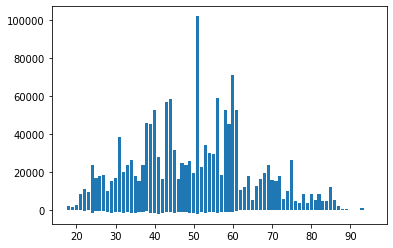

In [187]:
data['Total_deposits']=data['balance']*data['deposit']

plt.bar(data['age'],data['Total_deposits'])
plt.show()